## This is almost UNLIMITD-R, with the NN as mean function

In [1]:
import numpy as np
import gpytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.func import functional_call, vmap, vjp, jvp, jacrev
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

torch.manual_seed(42)
print(device)
print(np.__version__)
print(torch.__version__)
print(gpytorch.__version__)

cuda
1.24.3
2.0.0+cu117
1.11


## Tasks

In [2]:
class Sine_Task():
    """
    A sine wave data distribution object with interfaces designed for MAML.
    """
    def __init__(self, amplitude, phase, xmin, xmax):
        self.amplitude = amplitude
        self.phase = phase
        self.xmin = xmin
        self.xmax = xmax

    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        return self.amplitude * np.sin(self.phase + x)

    def sample_data(self, size=1, noise=0.0, sort=False):
        """
        Sample data from this task.

        returns:
            x: the feature vector of length size
            y: the target vector of length size
        """
        x = np.random.uniform(self.xmin, self.xmax, size)
        if(sort): x = np.sort(x)
        y = self.true_function(x)
        if(noise>0): y += np.random.normal(loc=0.0, scale=noise, size=y.shape)
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float)
        return x, y

In [3]:
class Task_Distribution():
    """
    The task distribution for sine regression tasks for MAML
    """

    def __init__(self, amplitude_min, amplitude_max, phase_min, phase_max, x_min, x_max, family="sine"):
        self.amplitude_min = amplitude_min
        self.amplitude_max = amplitude_max
        self.phase_min = phase_min
        self.phase_max = phase_max
        self.x_min = x_min
        self.x_max = x_max
        self.family = family

    def sample_task(self):
        """
        Sample from the task distribution.

        returns:
            Sine_Task object
        """
        amplitude = np.random.uniform(self.amplitude_min, self.amplitude_max)
        phase = np.random.uniform(self.phase_min, self.phase_max)
        if(self.family=="sine"):
            return Sine_Task(amplitude, phase, self.x_min, self.x_max)
        else:
            return None

## MODEL

In [4]:
class Feature(nn.Module):
    def __init__(self):
        super(Feature, self).__init__()
        self.layer1 = nn.Linear(1, 40)
        self.layer2 = nn.Linear(40,40)
        self.layer3 = nn.Linear(40,1)
        
    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = self.layer3(out)
        return out

In [5]:
def create_random_projection_matrix(n, subspace_dimension):
    """
    Create a projection matrix from R^n to a subspace of dimension `subspace_dimension`.
    
    Args:
    n (int): Dimension of the original space.
    subspace_dimension (int): Dimension of the target subspace.

    Returns:
    torch.Tensor: A (n x subspace_dimension) projection matrix.
    """
    # Check if subspace_dimension is not greater than n
    if subspace_dimension > n:
        raise ValueError("subspace_dimension must be less than or equal to n")

    # Generate a random n x subspace_dimension matrix
    random_matrix = torch.randn(n, subspace_dimension)

    # Perform QR decomposition to orthonormalize the columns
    q, _ = torch.linalg.qr(random_matrix)

    # Return the first 'subspace_dimension' columns of Q, which form an orthonormal basis
    return q[:, :subspace_dimension].T


## Unlimitd R

In [6]:
class NTKernel_proj(gpytorch.kernels.Kernel):
    def __init__(self, net, subspace_dimension, P1, **kwargs):
        super(NTKernel_proj, self).__init__(**kwargs)
        self.net = net
        self.sub_dim = subspace_dimension
        self.P1 = P1 # Projection matrix
        
        # Add 10 scaling parameters, initializing them as one
        self.scaling_param = nn.Parameter(torch.ones(subspace_dimension))

    def forward(self, x1, x2, diag=False, **params):
        jac1 = self.compute_jacobian(x1)
        jac2 = self.compute_jacobian(x2) if x1 is not x2 else jac1
        D = torch.diag(torch.pow(self.scaling_param, 2))
        
        # print("jac1.T shape:", jac1.T.shape)
        # print("P1 shape:", P1.T.shape)
        # print("D shape:", D.shape)
        # print("P1.T shape:", P1.shape)
        # print("jac2 shape:", jac2.shape)
        
        result = torch.chain_matmul(jac1, P1.T, D, P1, jac2.T)
        
        if diag:
            return result.diag()
        return result
    
    def compute_jacobian(self, inputs):
        """
        Return the jacobian of a batch of inputs, thanks to the vmap functionality
        """
        self.zero_grad()
        params = {k: v for k, v in self.net.named_parameters()}
        def fnet_single(params, x):
            return functional_call(net, params, (x.unsqueeze(0),)).squeeze(0)
        
        jac = vmap(jacrev(fnet_single), (None, 0))(params, inputs)
        jac = jac.values()
        # jac1 of dimensions [Nb Layers, Nb input / Batch, dim(y), Nb param/layer left, Nb param/layer right]
        reshaped_tensors = [
            j.flatten(2)                # Flatten starting from the 3rd dimension to acount for weights and biases layers
                .permute(2, 0, 1)         # Permute to align dimensions correctly for reshaping
                .reshape(-1, j.shape[0] * j.shape[1])  # Reshape to (c, a*b) using dynamic sizing
            for j in jac
        ]
        return torch.cat(reshaped_tensors, dim=0).T

In [7]:
class CosSimNTKernel_proj(gpytorch.kernels.Kernel):
    def __init__(self, net, subspace_dimension, P1, **kwargs):
        super(CosSimNTKernel_proj, self).__init__(**kwargs)
        self.net = net
        
        self.alpha = nn.Parameter(torch.ones(1))
        
        self.sub_dim = subspace_dimension
        self.P1 = P1 # Projection matrix
        
        # Add 10 scaling parameters, initializing them as one
        self.scaling_param = nn.Parameter(torch.ones(subspace_dimension))

    def forward(self, x1, x2, diag=False, **params):
        jac1 = self.compute_jacobian(x1)
        jac2 = self.compute_jacobian(x2) if x1 is not x2 else jac1
        
        D = torch.diag(self.scaling_param)
        
        result_1 = torch.chain_matmul(D, P1, jac1.T)
        result_2 = torch.chain_matmul(D, P1, jac2.T)
        
        result_1_norm = result_1.norm(dim=0, keepdim=True)
        result_1_normalized = result_1/result_1_norm
        #print(result_1.shape)
        #print(result_1.norm(dim=0, keepdim=True).shape)
        result_2_norm = result_2.norm(dim=0, keepdim=True)
        result_2_normalized = result_2/result_2_norm
        
        result = self.alpha * result_1_normalized.T@result_2_normalized
        
        if diag:
            return result.diag()
        return result
    
    def compute_jacobian(self, inputs):
        """
        Return the jacobian of a batch of inputs, thanks to the vmap functionality
        """
        self.zero_grad()
        params = {k: v for k, v in self.net.named_parameters()}
        def fnet_single(params, x):
            return functional_call(net, params, (x.unsqueeze(0),)).squeeze(0)
        
        jac = vmap(jacrev(fnet_single), (None, 0))(params, inputs)
        jac = jac.values()
        # jac1 of dimensions [Nb Layers, Nb input / Batch, dim(y), Nb param/layer left, Nb param/layer right]
        reshaped_tensors = [
            j.flatten(2)                # Flatten starting from the 3rd dimension to acount for weights and biases layers
                .permute(2, 0, 1)         # Permute to align dimensions correctly for reshaping
                .reshape(-1, j.shape[0] * j.shape[1])  # Reshape to (c, a*b) using dynamic sizing
            for j in jac
        ]
        return torch.cat(reshaped_tensors, dim=0).T

In [8]:
class ExactGPModel_proj(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, net, subspace_dimension, P1):
        super(ExactGPModel_proj, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = NTKernel_proj(net, subspace_dimension, P1)
        #self.covar_module = CosSimNTKernel_proj(net, subspace_dimension, P1)
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
        #self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=40)
        #self.feature_extractor = feature_extractor
        
    def forward(self, x):
        #z = self.feature_extractor(x)
        #z_normalized = z - z.min(0)[0]
        #z_normalized = 2 * (z_normalized / z_normalized.max(0)[0]) - 1
        #x_normalized = x - x.min(0)[0]
        #x_normalized = 2 * (x_normalized / x_normalized.max(0)[0]) - 1
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [9]:
n_shot_train = 10
n_shot_test = 5
train_range=(-5.0, 5.0)
test_range=(-5.0, 5.0) # This must be (-5, +10) for the out-of-range condition
subspace_dim = 10

criterion = nn.MSELoss()
tasks     = Task_Distribution(amplitude_min=0.1, amplitude_max=5.0, 
                                  phase_min=0.0, phase_max=np.pi, 
                                  x_min=train_range[0], x_max=train_range[1], 
                                  family="sine")

net       = Feature()
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.GreaterThan(1e-4))
# likelihood.noise = 1e-4
dummy_inputs = torch.zeros([n_shot_train,1])
dummy_labels = torch.zeros([n_shot_train])


P1 = create_random_projection_matrix(sum(p.numel() for p in net.parameters()), subspace_dim)
gp = ExactGPModel_proj(dummy_inputs, dummy_labels, likelihood, net, subspace_dim, P1)
trainable_params = sum(p.numel() for p in gp.parameters() if p.requires_grad)
print(trainable_params)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)
optimizer = torch.optim.Adam([{'params': gp.parameters(), 'lr': 1e-3}])

1772


In [10]:
tot_iterations=50000
for epoch in range(tot_iterations):
    # gp.likelihood.noise = 1e-2
    optimizer.zero_grad()
    inputs, labels = tasks.sample_task().sample_data(n_shot_train, noise=0.05)
    
    gp.set_train_data(inputs=inputs, targets=labels - net(inputs).reshape(-1))  
    predictions = gp(inputs)
    loss = -mll(predictions, gp.train_targets)
    loss.backward()
    optimizer.step()
    #---- print some stuff ----
    if(epoch%1000==0):
        mse = criterion(predictions.mean, labels)
        print(predictions.mean)
        print('[%d] - Loss: %.3f  MSE: %.3f  lengthscale: %.3f   noise: %.3f' % (
            epoch, loss.item(), mse.item(),
            0.0, #gp.covar_module.base_kernel.lengthscale.item(),
            gp.likelihood.noise.item()
        ))

/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a-pytorch/lib/python3.9/site-packages/torch/functional.py:1626: UserWarning: torch.chain_matmul is deprecated and will be removed in a future PyTorch release. Use torch.linalg.multi_dot instead, which accepts a list of two or more tensors rather than multiple parameters. (Triggered internally at ../aten/src/ATen/native/LinearAlgebra.cpp:1079.)
  return _VF.chain_matmul(matrices)  # type: ignore[attr-defined]


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[0] - Loss: 1.380  MSE: 0.868  lengthscale: 0.000   noise: 0.694
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[1000] - Loss: 1.115  MSE: 1.021  lengthscale: 0.000   noise: 0.781
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[2000] - Loss: 1.477  MSE: 8.080  lengthscale: 0.000   noise: 0.654
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[3000] - Loss: 1.030  MSE: 0.130  lengthscale: 0.000   noise: 0.439
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[4000] - Loss: 1.430  MSE: 9.265  lengthscale: 0.000   noise: 0.240
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[5000] - Loss: 0.888  MSE: 11.265  lengthscale: 0.000   noise: 0.125
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[6000] - Loss: 0.686  MSE: 1.731  lengthscale: 0.000   noise: 0.070
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[7000] - Loss: 0.509  MSE: 7.112  lengthscale: 0.000   noise: 0.044
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[8000] - Loss: 0.

## Test Phase

In [11]:
tasks_test = Task_Distribution(amplitude_min=0.1, amplitude_max=5.0, 
                                phase_min=0.0, phase_max=np.pi, 
                                x_min=test_range[0], x_max=test_range[1], 
                                family="sine")

sample_task = tasks_test.sample_task()

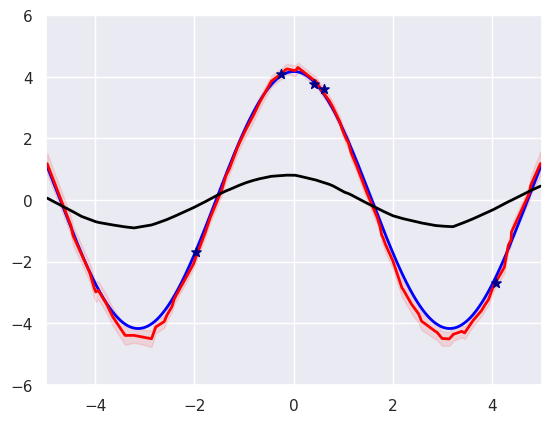

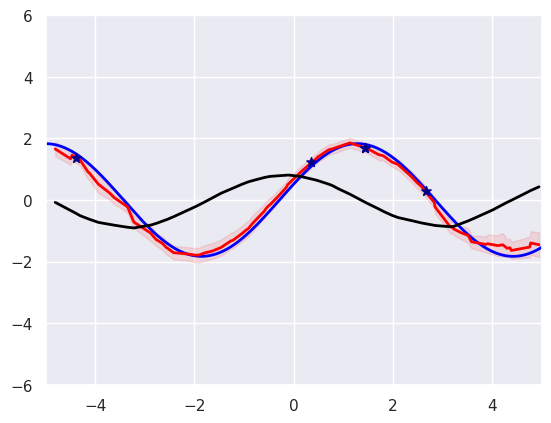

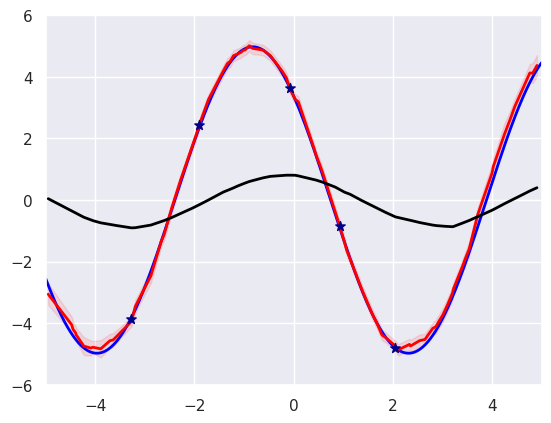

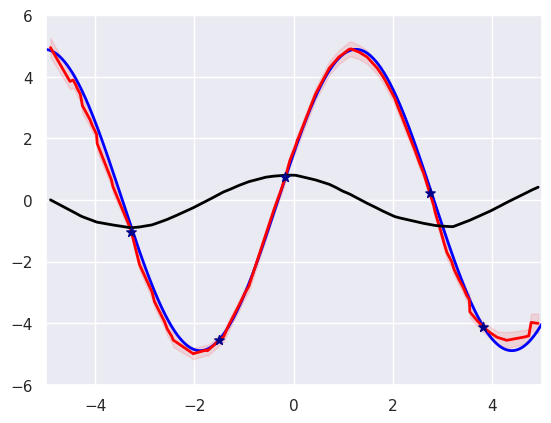

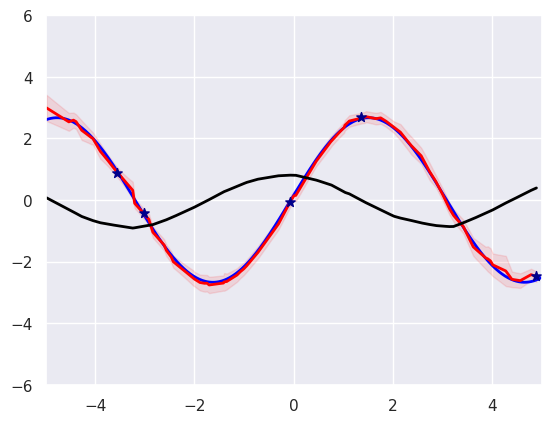

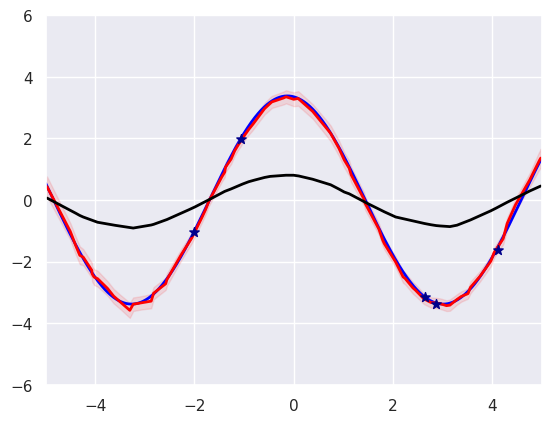

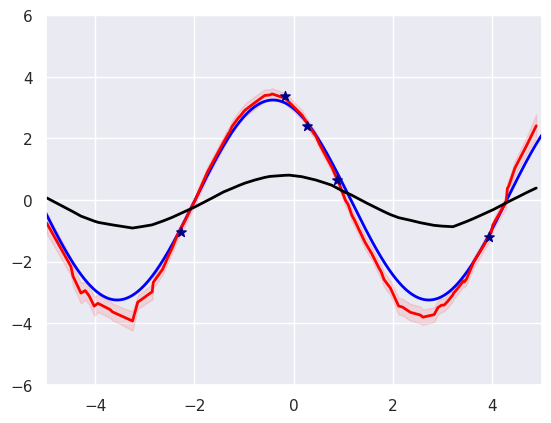

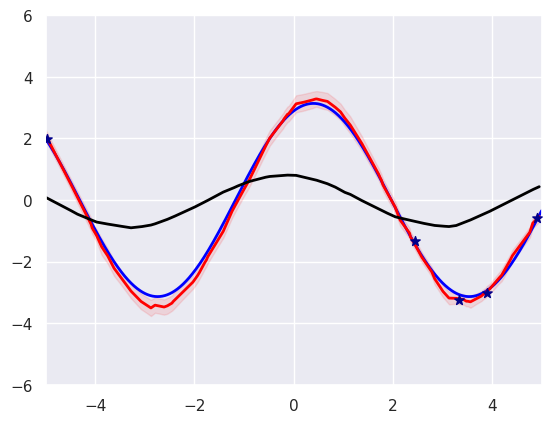

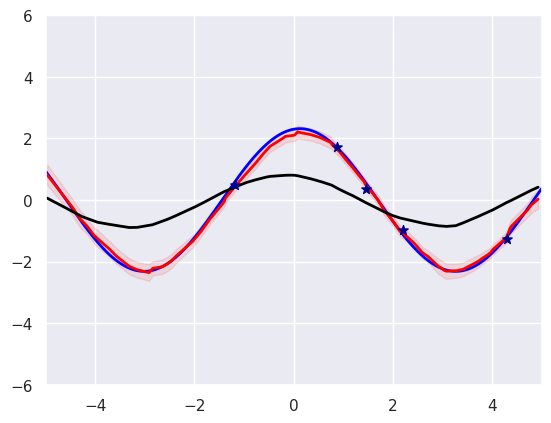

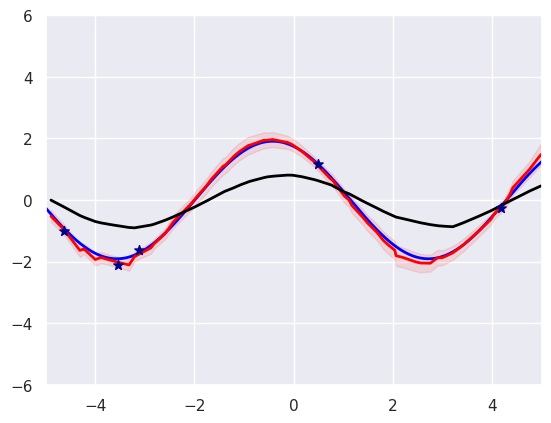

In [12]:
sample_size = 200

likelihood.eval()
net.eval()
gp.covar_module.eval()
# for param in net.parameters():
#     param.requires_grad_(False)
    
for i in range(10):
    sample_task = tasks_test.sample_task()
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    query_indices = np.sort(indices[n_shot_test:])
    support_indices = np.sort(indices[0:n_shot_test])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support - net(x_support).reshape(-1), strict=False)  
    gp.eval()
            
    #Evaluation on all data
    mean = likelihood(gp(x_all)).mean + net(x_all).reshape(-1)
    lower, upper = likelihood(gp(x_all)).confidence_region() #2 standard deviations above and below the mean
    lower += net(x_all).reshape(-1)
    upper += net(x_all).reshape(-1)    
    
    #Plot
    fig, ax = plt.subplots()
    #true-curve
    true_curve = np.linspace(train_range[0], train_range[1], 1000)
    true_curve = [sample_task.true_function(x) for x in true_curve]
    ax.plot(np.linspace(train_range[0], train_range[1], 1000), true_curve, color='blue', linewidth=2.0)
    if(train_range[1]<test_range[1]):
        dotted_curve = np.linspace(train_range[1], test_range[1], 1000)
        dotted_curve = [sample_task.true_function(x) for x in dotted_curve]
        ax.plot(np.linspace(train_range[1], test_range[1], 1000), dotted_curve, color='blue', linestyle="--", linewidth=2.0)
    #query points (ground-truth)
    #ax.scatter(x_query, y_query, color='blue')
    #query points (predicted)

    ax.plot(np.squeeze(x_all), mean.detach().numpy(), color='red', linewidth=2.0)
    ax.plot(np.squeeze(x_all), net(x_all).reshape(-1).detach().numpy(), color='black', linewidth=2.0)
    ax.fill_between(np.squeeze(x_all),
                    lower.detach().numpy(), upper.detach().numpy(),
                    alpha=.1, color='red')
    #support points
    ax.scatter(x_support, y_support, color='darkblue', marker='*', s=50, zorder=10)
                    
    #all points
    #ax.scatter(x_all.numpy(), y_all.numpy())
    #plt.show()
    plt.ylim(-6.0, 6.0)
    plt.xlim(test_range[0], test_range[1])
    #plt.savefig('plot_DKT_' + str(i) + '.png', dpi=300)

In [13]:
print("Test, please wait...")

likelihood.eval()
net.eval()
tot_iterations=500
mse_list = list()
for epoch in range(tot_iterations):
    sample_task = tasks_test.sample_task()
    sample_size = 200
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    support_indices = np.sort(indices[0:n_shot_test])

    query_indices = np.sort(indices[n_shot_test:])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    #Feed the support set
    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support - net(x_support).reshape(-1), strict=False)  
    gp.eval()

    #Evaluation on query set
    mean = likelihood(gp(x_query)).mean + net(x_query).reshape(-1)

    mse = criterion(mean, y_query)
    mse_list.append(mse.item())

print("-------------------")
print("Average MSE: " + str(np.mean(mse_list)) + " +- " + str(np.std(mse_list)))
print("-------------------")

Test, please wait...
-------------------
Average MSE: 0.03185269053839147 +- 0.02190826517586459
-------------------


In [14]:
print(gp.covar_module.scaling_param)

Parameter containing:
tensor([5.5697, 0.0224, 3.1416, 1.7482, 4.7209, 0.2134, 0.0886, 0.2054, 0.1339,
        0.0947], requires_grad=True)
